# Gaussian Example

In this example, we consider a one-dimensional Gaussian distribution at the particle level and two Gaussian distributions at the detector level. The data are generated as follows:
\begin{aligned}
    Y_{i1} &= X_{i} + Z_{i1}, \\
    Y_{i2} &= X_{i} + Z_{i2},
\end{aligned}
where $X_i\sim\mathcal{N}(\mu,\sigma^2), Z_{i1}\sim\mathcal{N}(0,1), Z_{i2}\sim\mathcal{N}(0,\theta^2)$. Here, $\theta$ is the nuisance parameter, which only affects the second dimension of the detector-level data. 

In [1]:
# Standard stuff
import numpy as np
import pandas as pd
from scipy.stats import norm
import copy

# Pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

# POF functions
import utils
import profile_omnifold as pof

dvc = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {dvc} device")

2025-03-09 20:57:42.574061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 20:57:42.761661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 20:57:42.830506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 20:57:43.241511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 20:57:46.391878: W tensorflow/compiler/tf2

Using cuda device


## Generate Gaussian Data

In [2]:
# specify the nuisance parameter
theta = 1.5

In [3]:
# smearing kernel for the MC data
mu_kernel_mc = 0
sigma1_kernel_mc = 1
sigma2_kernel_mc = 1

# smearing kernel for the experimental data
mu_kernel_data = 0
sigma1_kernel_data = 1
sigma2_kernel_data = theta

def k_mc(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_mc,scale=sigma1_kernel_mc)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_mc,scale=sigma2_kernel_mc)

def k_data(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=sigma1_kernel_data)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_data,scale=sigma2_kernel_data)

# reweighting function w parametrized by theta
# w(x,y,theta) = p(y|x,theta)/p(y|x,mc)
def w_func(x,y,theta):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=sigma1_kernel_data)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_data,scale=theta)/k_mc(y,x)

# derivative of w with respect to theta
def w_func_derivative(x,y,theta):
    return ((y[:,1]-x[:,0])**2/(theta**3)-1/theta)*w_func(x,y,theta)

# true reweighting function on the MC response kernel (i.e. k_data/k_mc)
def w_true(x,y):
    return k_data(y,x)/k_mc(y,x)

### Experimental Data (Nature)

In [4]:
# specify the parameters for the particle-level distribution
mu_data = 0.8
sigma_data = 1

def px(x):
    return norm.pdf(x,loc=mu_data,scale=sigma_data)
def py1(y):
    return norm.pdf(y,loc=mu_data+mu_kernel_data,scale=np.sqrt(sigma_data**2+sigma1_kernel_data**2))
def py2(y):
    return norm.pdf(y,loc=mu_data+mu_kernel_data,scale=np.sqrt(sigma_data**2+sigma2_kernel_data**2))


# sample from the experimental distribution
Ndata = 10000
x_data = np.random.normal(loc=mu_data,scale=sigma_data,size=Ndata).reshape(-1,1)
y_data1 = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma1_kernel_data,size=Ndata).reshape(-1,1)
y_data2 = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma2_kernel_data,size=Ndata).reshape(-1,1)
y_data = np.hstack([y_data1, y_data2])

### Monte Carlo Data (Simulation)

In [5]:
# specify the parameters for the particle-level distribution
mu_mc = 0
sigma_mc = 1


def qx(x):
    return norm.pdf(x,loc=mu_mc,scale=sigma_mc)
def qy1(y):
    return norm.pdf(y,loc=mu_mc+mu_kernel_mc,scale=np.sqrt(sigma_mc**2+sigma1_kernel_mc**2))
def qy2(y):
    return norm.pdf(y,loc=mu_mc+mu_kernel_mc,scale=np.sqrt(sigma_mc**2+sigma2_kernel_mc**2))


# sample from the MC distribution
Nsim = 50000
x_mc = np.random.normal(loc=mu_mc,scale=sigma_mc,size=Nsim).reshape(-1,1)
y_mc1 = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma1_kernel_mc,size=Nsim).reshape(-1,1)
y_mc2 = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma2_kernel_mc,size=Nsim).reshape(-1,1)
y_mc = np.hstack([y_mc1,y_mc2])

### Systematic Data (varying theta, used for training W function)

In [6]:
Nsys = 50000
# simulation with theta variation
theta_min = 0.5
theta_max = 4

theta0_sim = np.random.uniform(theta_min, theta_max, Nsys).reshape(-1, 1)
theta1_sim = np.random.uniform(theta_min, theta_max, Nsys).reshape(-1, 1)

thetas = theta1_sim[:,0]

x_sys = np.random.normal(loc=mu_mc,scale=sigma_mc,size=Nsys).reshape(-1,1)

y_nominal1 = np.random.normal(loc=x_sys[:,0],scale=sigma1_kernel_mc,size=Nsys).reshape(-1,1)
y_nominal2 = np.random.normal(loc=x_sys[:,0],scale=sigma2_kernel_mc,size=Nsys).reshape(-1,1)
y_nominal = np.hstack([y_nominal1,y_nominal2])

y_sys1 = np.random.normal(loc=x_sys[:,0],scale=sigma1_kernel_mc,size=Nsys).reshape(-1,1)
y_sys2 = []
for i in range(Nsys):
    y_sys2.append(np.random.normal(x_sys[i,0], theta1_sim[i,0]))
y_sys2 = np.array(y_sys2).reshape(-1,1)
y_sys = np.hstack([y_sys1,y_sys2])

## Train W model

We train a neural network (NN) model to learn the W function, which represents the ratio of the response kernel parametrized by $\theta$ to the Monte Carlo (MC) kernel, i.e. $w(y,x,\theta)=p(y|x,\theta)/q(y|x)$.

In this example, we know that the response kernel follows a Gaussian distribution, meaning the analytic form of the W function is also known. As a result, training the W model is not necessary to run the ProfileOmniFold algorithm. Instead, we can use the true W function `w_func` as a direct alternative in the next section if preferred.

In [7]:
# hyperparameters for training the neural network
config = {
    'batch_size': 10000,
    'lr': 0.001,
    'patience': 30,
    'activation': nn.ReLU()
}

In [8]:
# Convert data into W dataset, data loaders and create loss function
w_ds = pof.w_dataset(x_mc, y_mc, theta0_sim, x_sys, y_sys, theta1_sim)

# split samples to 50% train and 50% test sets
w_ds_train, w_ds_test = random_split(w_ds, [len(w_ds)//2, len(w_ds)-len(w_ds)//2])
w_dataloader_train = DataLoader(w_ds_train, batch_size=100000, shuffle=True)
w_dataloader_test = DataLoader(w_ds_test, batch_size=100000, shuffle=False)

In [9]:
# Train W model

wRT_model_network = pof.wRT_network(sigmoid=True, n_inputs=4, activation=config['activation']).double().to(dvc)
optimizerRT = optim.Adam(wRT_model_network.parameters(), lr=config['lr'])
loss_fn_RT = nn.BCELoss()
wRT_tr = pof.w_trainer(w_dataloader_train, w_dataloader_test, wRT_model_network, loss_fn_RT, optimizerRT, patience=config['patience'])

wT_model_network = pof.wT_network(sigmoid=True, n_inputs=2, activation=config['activation']).double().to(dvc)
optimizerT = optim.Adam(wT_model_network.parameters(), lr=config['lr'])
loss_fn_T = nn.BCELoss()
wT_tr = pof.w_trainer(w_dataloader_train, w_dataloader_test, wT_model_network, loss_fn_T, optimizerT)

wRT_tr.fit()
wT_tr.fit()

===================== Model W =====================
wRT_network(
  (linear_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (activation_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W =====================
wT_network(
  (linear_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (activation_0): ReL

In [10]:
# optionally, save the models for later access
wRT_checkpoint = {
    "model_state_dict": wRT_model_network.state_dict(),
    "config": config,
    "num_sys": Nsys,
    "num_mc": Nsim,
    "theta_min": theta_min,
    "theta_max": theta_max
}
wT_checkpoint = {
    "model_state_dict": wT_model_network.state_dict(),
    "config": config,
    "num_sys": Nsys,
    "num_mc": Nsim,
    "theta_min": theta_min,
    "theta_max": theta_max
}

torch.save(wRT_checkpoint, "models/2DGaussian/wRT_network_2dgaussian.pth")
torch.save(wT_checkpoint, "models/2DGaussian/wT_network_2dgaussian.pth")

In [13]:
# load the models if saved previously
wRT_model_network = pof.wRT_network(sigmoid=True, n_inputs=4).double().to(dvc)
wT_model_network = pof.wT_network(sigmoid=True, n_inputs=2).double().to(dvc)

wRT_model_network.load_state_dict(torch.load("models/2DGaussian/wRT_network_2dgaussian.pth")["model_state_dict"])
wT_model_network.load_state_dict(torch.load("models/2DGaussian/wT_network_2dgaussian.pth")["model_state_dict"])

<All keys matched successfully>

In [14]:
# wrap the w function on the MC dataset (so that it becomes only a function of theta)
ds = pof.test_dataset(x_mc, y_mc)
ds_dataloader = DataLoader(ds, batch_size=100000, shuffle=False)
w_theta_nn = pof.make_w_theta(ds_dataloader, wRT_model_network, wT_model_network)
w_theta_nn_grad = pof.make_w_theta_grad(ds_dataloader, wRT_model_network, wT_model_network)

## Profile OmniFold Algorithm

Now, let's run the algorithm! There are two options:  

1. **Gradient-Based Approach** – This version requires computing the gradient of the w function with respect to $\theta$.  
2. **Grid Search Approach** – This version does not require the gradient but instead performs a grid search over $\theta$ to find the optimum.  

When $\theta$ is low-dimensional, the **grid search approach** may be preferred.  

Additionally, during unfolding, we need to provide the **w function** (a function of $\theta$) as an input to the algorithm. We can either:  
- Use the fitted w function, `w_theta_nn`, obtained above.  
- Use the true w function, `w_func`, since we know the smearing kernel is Gaussian.  

In [15]:
# use the NN solution
w_theta = w_theta_nn
w_theta_grad = w_theta_nn_grad

In [20]:
# use the true function
def w_theta(theta):
    return w_func(x_mc, y_mc, theta)
def w_theta_grad(theta):
    return w_func_derivative(x_mc, y_mc, theta)

In [ ]:
# gradient-based approach
nu_pof = pof.profile_omnifold(y_data, x_mc, y_mc, w_theta, w_theta_grad, theta_bar=1.0, theta0=1.0, no_penalty=True, theta_range=[0.5,2.0])

In [21]:
# no gradient approach
nu_pof = pof.profile_omnifold_no_grad(y_data, x_mc, y_mc, 10, w_theta, theta_bar=1.0, theta0=1.3, theta_range=[1.0,2.0], num_grid_points=30,
                                               no_penalty=True, verbose=0)

fitting w on grid points...
Initial Theta: 1.3

ITERATION: 1

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 3

Value of Theta before update: 1.3
Updated value of Theta: 1.0689655172413792

ITERATION: 2

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

STEP 3

Value of Theta before update: 1.0689655172413792
Updated value of Theta: 1.103448275862069

ITERATION: 3

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 3

Value of Theta before update: 1.103448275862069
Updated value of Theta: 1.3448275862068966

ITERATION: 4

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 3

Value of Theta before update: 1.3448275862068966
Updated value of Theta: 1.4137931034482758

ITERATION: 5

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 3

Value o

In [17]:
# As a comparison, we can also run the vanilla omnifold algorithm
nu_of = pof.omnifold(y_data, x_mc, y_mc, 10, verbose=0)


ITERATION: 1

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 2

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 3

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 4

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 5

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 6

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 7

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 8

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION: 9

STEP 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

STEP 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

ITERATION

### Plot the results

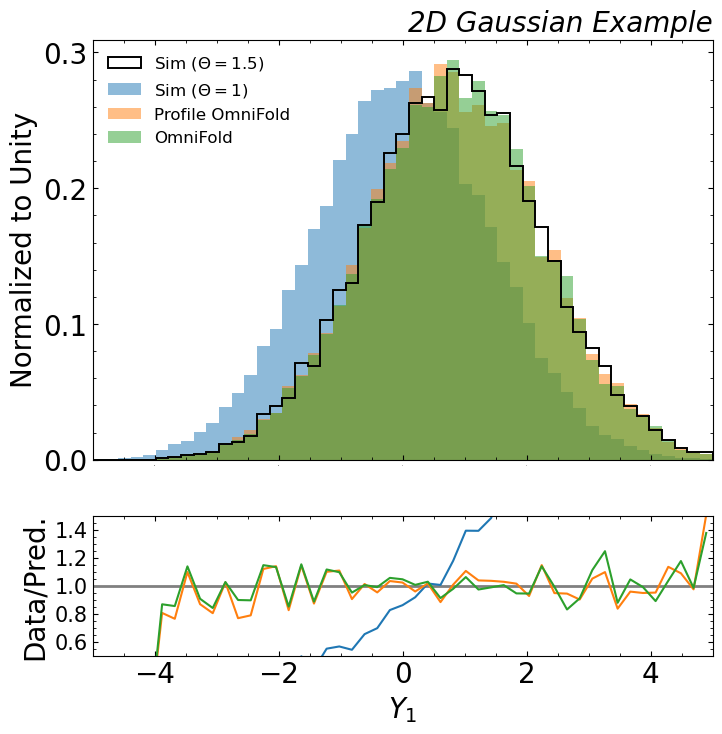

<Figure size 640x480 with 0 Axes>

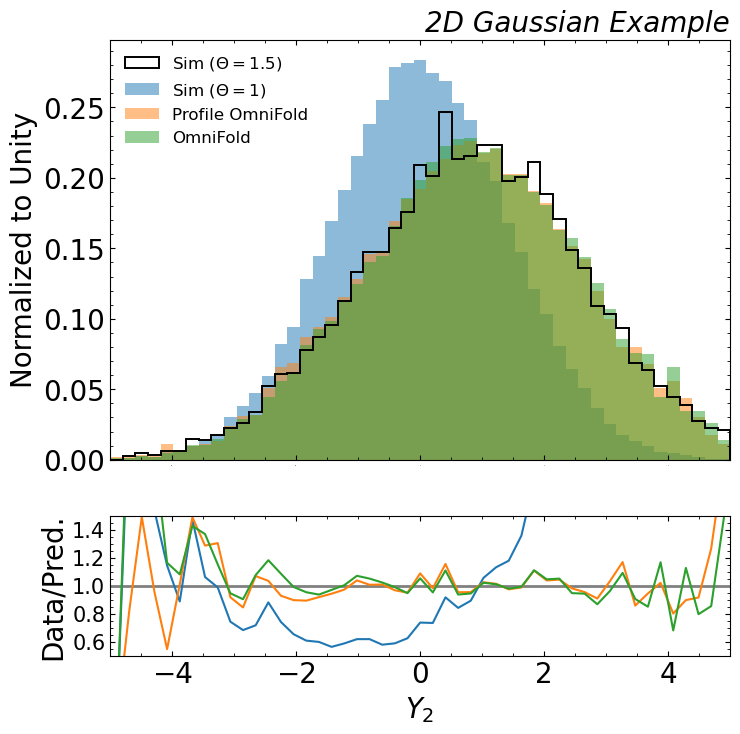

<Figure size 640x480 with 0 Axes>

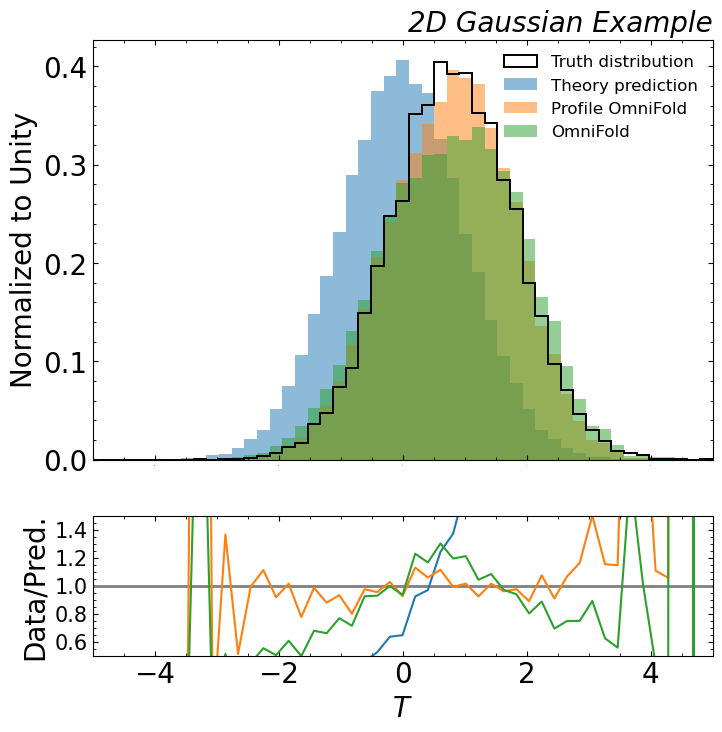

fitted theta: 1.4827586206896552


<Figure size 640x480 with 0 Axes>

In [22]:
# indicate which iteration to plot
i = 9

cpwr = utils.comparison_plots_with_ratio(-5, 5, 50, xlabel=r"$Y_1$", density=True, header="2D Gaussian Example")
cpwr.add_data(y_data[:,0], label=f"Sim ($\Theta={theta}$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(y_mc[:,0], label=r"Sim ($\Theta=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(y_mc[:,0], weights=nu_pof[i,0,:]*nu_pof[i,2,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(y_mc[:,0], weights=nu_of[i,0,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

cpwr = utils.comparison_plots_with_ratio(-5, 5, 50, xlabel=r"$Y_2$", density=True, header="2D Gaussian Example")
cpwr.add_data(y_data[:,1], label=f"Sim ($\Theta={theta}$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(y_mc[:,1], label=r"Sim ($\Theta=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(y_mc[:,1], weights=nu_pof[i,0,:]*nu_pof[i,2,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(y_mc[:,1], weights=nu_of[i,0,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

cpwr = utils.comparison_plots_with_ratio(-5, 5, 50, xlabel=r"$T$", density=True, legend_corner="upper right", header="2D Gaussian Example")
cpwr.add_data(x_data, label="Truth distribution", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(x_mc, label="Theory prediction", alpha=0.5, color='tab:blue')
cpwr.add_data(x_mc, weights=nu_pof[i,1,:], label="Profile OmniFold", alpha=0.5, color='tab:orange')
cpwr.add_data(x_mc, weights=nu_of[i,1,:], label="OmniFold", alpha=0.5, color='tab:green')
cpwr.show()

print('fitted theta:', nu_pof[i,3,0])